In [1]:
"""
Purpose: To practice retrieving decimated meshes
from the segmentation = 3 version of the Platinum data

"""

'\nPurpose: To practice retrieving decimated meshes\nfrom the segmentation = 3 version of the Platinum data\n\n'

# Modules for Datajoint

In [2]:
import numpy as np
import datajoint as dj
import trimesh
from tqdm.notebook import tqdm
from pathlib import Path

In [3]:
import minfig

minnie = minfig.configure_minnie(return_virtual_module=True)

Connecting celiib@10.28.0.34:3306


# Modules for Soma Extraction

In [26]:
from os import sys
sys.path.append('/meshAfterParty/')

from soma_extraction_utils import *

In [21]:
minnie.Decimation() & "version = 0 AND decimation_ratio=0.10"

segment_id segment id unique within each Segmentation,version,decimation_ratio ratio of remaining mesh vertices/faces (which ones depends on what metric the decimation technique uses),n_vertices,n_faces,mesh in-place path to the hdf5 (decimated) mesh file
81298440117723637,0,0.10,269,534,=BLOB=
82144101864319188,0,0.10,1327,2662,=BLOB=
82354108719290154,0,0.10,8789,18102,=BLOB=
82354589755676405,0,0.10,308,620,=BLOB=
83551889601392266,0,0.10,5828,11926,=BLOB=
83620952205786518,0,0.10,16,28,=BLOB=
85385324972393820,0,0.10,5429,13266,=BLOB=
85661852146667859,0,0.10,787,1544,=BLOB=
86013489575105352,0,0.10,11,18,=BLOB=
86083858319278158,0,0.10,8,12,=BLOB=


In [20]:
minnie.Decimation() & "version = 0 AND decimation_ratio=0.25"

segment_id segment id unique within each Segmentation,version,decimation_ratio ratio of remaining mesh vertices/faces (which ones depends on what metric the decimation technique uses),n_vertices,n_faces,mesh in-place path to the hdf5 (decimated) mesh file
72347797059274433,0,0.25,595,1298,=BLOB=
72489015583974589,0,0.25,800,1652,=BLOB=
72489634059263423,0,0.25,545,1134,=BLOB=
72489771498209954,0,0.25,287,602,=BLOB=
72558422322577481,0,0.25,338,708,=BLOB=
72558972078398291,0,0.25,2703,5686,=BLOB=
72627554116173963,0,0.25,581,1282,=BLOB=
72628241243834220,0,0.25,1519,3322,=BLOB=
72628241310954582,0,0.25,486,1052,=BLOB=
72628447469385540,0,0.25,366,760,=BLOB=


In [4]:
m65 = dj.create_virtual_module('m65', 'microns_minnie65_01')
schema = dj.schema("microns_minnie65_01")

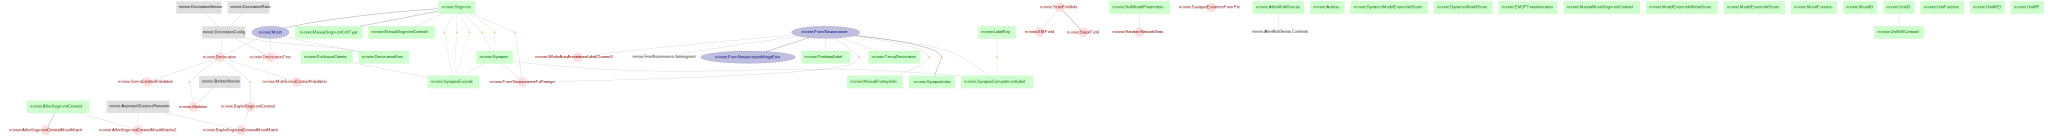

In [14]:
dj.ERD(minnie)

In [13]:
minnie.Decimation.describe()

# Decimated meshes
-> minnie.Mesh
-> minnie.DecimationConfig
---
n_vertices           : bigint                       
n_faces              : bigint                       
mesh                 : <decimated_mesh>             # in-place path to the hdf5 (decimated) mesh file
INDEX (mesh)



'# Decimated meshes\n-> minnie.Mesh\n-> minnie.DecimationConfig\n---\nn_vertices           : bigint                       \nn_faces              : bigint                       \nmesh                 : <decimated_mesh>             # in-place path to the hdf5 (decimated) mesh file\nINDEX (mesh)\n'

In [22]:
m65 = dj.create_virtual_module('m65', 'microns_minnie65_01')
schema = dj.schema("microns_minnie65_01")

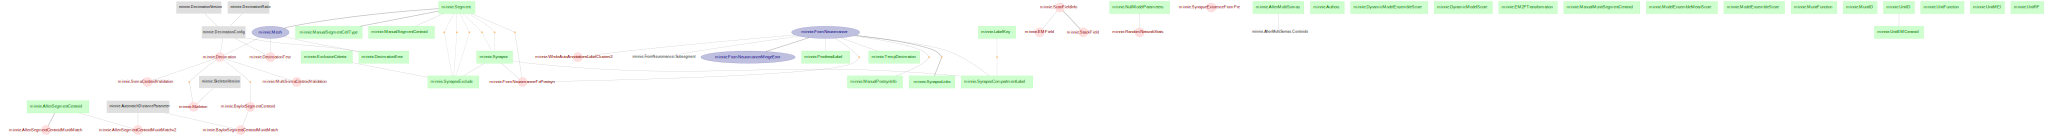

In [23]:
dj.ERD(schema)

In [ ]:
decimation_version = 0
decimation_ratio = 0.25

@schema
class BaylorSegmentCentroidSeg3(dj.Computed):
    definition="""
    -> minnie.Decimation.proj(decimation_version='version')
    soma_index : tinyint unsigned #index given to this soma to account for multiple somas in one base semgnet
    ---
    centroid_x=NULL           : int unsigned                 # (EM voxels)
    centroid_y=NULL           : int unsigned                 # (EM voxels)
    centroid_z=NULL           : int unsigned                 # (EM voxels)
    n_vertices=NULL           : bigint                 #number of vertices
    n_faces=NULL            : bigint                  #number of faces
    soma_vertices=NULL        : longblob                # array of vertices
    soma_faces=NULL           : longblob                   # array of faces
    multiplicity=NULL         : tinyint unsigned             # the number of somas found for this base segment
    sdf=NULL                  : double                       # sdf width value for the soma
    max_side_ratio=NULL       : double                       # the maximum of the side length ratios used for check if soma
    bbox_volume_ratio=NULL    : double                       # ratio of bbox (axis aligned) volume to mesh volume to use for check if soma
    run_time=NULL : double                   # the amount of time to run (seconds)

    """
    
    segments = (m65.Mesh() & f'n_vertices  > {np.str(np.round(np.exp(12)).astype(np.int))}' & f'n_vertices  < {np.str(np.round(np.exp(15)).astype(np.int))}')
    key_source =  minnie.Decimation.proj(decimation_version='version') & segments.proj() & "decimation_version=" + str(decimation_version)
    
    def make(self,key):
        #get the mesh data
        print(f"\n\n\n---- Working on {key['segment_id']} ----")

        new_mesh = (minnie.Decimation() & key).fetch1("mesh")
        current_mesh_verts,current_mesh_faces = new_mesh.vertices,new_mesh.faces

        segment_id = key["segment_id"]

        (total_soma_list, 
         run_time, 
         total_soma_list_sdf) = extract_soma_center(
                            segment_id,
                            current_mesh_verts,
                            current_mesh_faces,
                            outer_decimation_ratio= 0.25,
                            large_mesh_threshold = 60000,
                            large_mesh_threshold_inner = 40000,
                            soma_width_threshold = 0.32,
                            soma_size_threshold = 20000,
                           inner_decimation_ratio = 0.25,
                           volume_mulitplier=7,
                           side_length_ratio_threshold=3,
                            soma_size_threshold_max=192000,
                            delete_files=True
        print(f"Run time was {run_time} \n    total_soma_list = {total_soma_list}"
             f"\n    with sdf values = {total_soma_list_sdf}")
        
        #check if soma list is empty and did not find soma
        if len(total_soma_list) <= 0:
            print("There were no somas found for this mesh so just writing empty data")
            insert_dict = dict(key,
                              soma_index=0,
                              centroid_x=None,
                               centroid_y=None,
                               centroid_z=None,
                               #distance_from_prediction=None,
                               #prediction_matching_index = None,
                               n_vertices=0,
                               n_faces=0,
                               soma_vertices=None,
                               soma_faces=None,
                               multiplicity=0,
                               sdf = None,
                               max_side_ratio = None,
                               bbox_volume_ratio = None,
                               run_time=run_time
                              )
            
            #raise Exception("to prevent writing because none were found")
            self.insert1(insert_dict,skip_duplicates=True)
            return
        
        #if there is one or more soma found, get the volume and side length checks
        max_side_ratio =  [np.max(side_length_ratios(m)) for m in total_soma_list]
        bbox_volume_ratio =  [soma_volume_ratio(m) for m in total_soma_list]
        dicts_to_insert = []


        for i,(current_soma,soma_sdf,sz_ratio,vol_ratio) in enumerate(zip(total_soma_list,total_soma_list_sdf,max_side_ratio,bbox_volume_ratio)):
            print("Trying to write off file")
            """ Currently don't need to export the meshes
            current_soma.export(f"{key['segment_id']}/{key['segment_id']}_soma_{i}.off")
            """
            auto_prediction_center = np.mean(current_soma.vertices,axis=0) / np.array([4,4,40])
            auto_prediction_center = auto_prediction_center.astype("int")
            print(f"Predicted Coordinates are {auto_prediction_center}")



            insert_dict = dict(key,
                              soma_index=i+1,
                              centroid_x=auto_prediction_center[0],
                               centroid_y=auto_prediction_center[1],
                               centroid_z=auto_prediction_center[2],
        #                                distance_from_prediction=error_distance,
        #                                prediction_matching_index = prediction_matching_index,
                               n_vertices = len(current_soma.vertices),
                               n_faces = len(current_soma.faces),
                               soma_vertices=current_soma.vertices,
                               soma_faces=current_soma.faces,
                               multiplicity=len(total_soma_list),
                               sdf = np.round(soma_sdf,3),
                               max_side_ratio = np.round(sz_ratio,3),
                               bbox_volume_ratio = np.round(vol_ratio,3),
                               run_time=np.round(run_time,4)
                              )



            dicts_to_insert.append(insert_dict)

        self.insert(dicts_to_insert,skip_duplicates=True)
    )